In [1]:
from environment import *

In [2]:
# PRINT OUT POPULATIONS FOR MAIN AIRPORTS
print("\nlondon", populations.iloc[LHR])
print("\ndubai", populations.iloc[DXB])
print("\nhongkong", populations.iloc[HKG])
print("\njfk", populations.iloc[JFK])


london population    8.336719e+06
Name: LHR, dtype: float64

dubai population    3.968908e+06
Name: DXB, dtype: float64

hongkong population    2.838711e+07
Name: HKG, dtype: float64

jfk population    8.081095e+06
Name: JFK, dtype: float64


### Run Baseline Simulation

In [3]:
# Params
n_iters = 200
n_days = n_iters

beta = 3
decay = 5
eps = 1/7
gamma = 1/25
delta = 1/(2*365)

# Initiate Environment
env = EpidemicEnvironment(vals(adj_matrix), 
                          vals(populations), 
                          ATL, 
                          get_community(ATL), 
                          infected_idx = WUH, 
                          alphas_plus = vals(alphas), 
                          lmbda = 10, 
                          mu = 0.2, 
                          centrality = centralities.values, 
                          gamma = gamma,
                          delta = delta, 
                          beta = beta, 
                          epsilon = eps, 
                          beta_reduced = beta, 
                          decay = decay)

# Always call to be sure
env.reset()

# Run Simulation
for i in range(n_days):
    env.step(0)

### Diagnostics

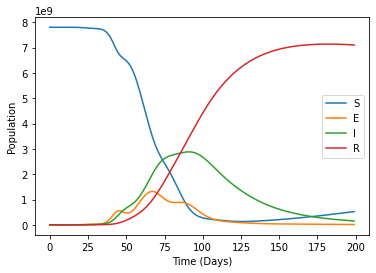

In [4]:
# Visualising global states
# global_compartments_over_time = env.stateHistory[:,:,LHR]
global_compartments_over_time = env.stateHistory.sum(axis=2)
plt.plot(global_compartments_over_time)
plt.legend(['S','E','I','R'])
plt.xlabel('Time (Days)')
plt.ylabel('Population')
plt.show()

In [5]:
max_peak_infections = env.stateHistory[:,2,:].sum(axis=1).max()
print(max_peak_infections)
max_total_infections = env.stateHistory[:,3,:].sum(axis=1).max()
print(max_total_infections)

2885487730.5877514
7138688697.766091


### Close All After N Days

In [60]:
def fitness_function_gen_analysis(n_days):
    def fitness_function(X):
        # 1. Compute the peak infections and total recoveries
        gamma = 1/25
        beta = 3 # We make this really high to reduce the number of iterations required.
        decay = 5
        eps = 1/7
        n_iters = 200
        country_to_disable = np.array(X, dtype=np.bool_)

        mapping = airport_country.reset_index()
        mapping.columns = ['IATA', 'country_IATA']

        # Airports
        to_disable = mapping['country_IATA'].isin(list(countries[country_to_disable])).values

        # As calculated during previous simulation
        max_peak_infections = 2885487730.5877514
        max_total_infections = 7138688697.766091

        env = EpidemicEnvironment(vals(adj_matrix), 
                                  vals(populations), 
                                  ATL, 
                                  get_community(ATL), 
                                  infected_idx = WUH, 
                                  alphas_plus = vals(alphas),
                                  lmbda = 10, 
                                  mu = 0.2, 
                                  centrality = centralities.values, 
                                  gamma = gamma, 
                                  beta = beta, 
                                  epsilon = eps, 
                                  beta_reduced = beta,
                                  decay = decay)

        env.reset()

        for i in range(n_days):
            env.step(0)

        env.set_disabled_airports(to_disable)

        for i in range(n_iters - n_days):
            env.step(0)

        infections = env.stateHistory[:,2,:].sum(axis=1)
        recoveries = env.stateHistory[:,3,:].sum(axis=1)
        population = env.stateHistory[0,:,:].sum()

        peak_infections = infections.max()
        total_infections = recoveries.max()

        reduced_pct_infections = (1 - (infections.max() / max_peak_infections))
        reduced_pct_recoveries = (1 - (recoveries.max() / max_total_infections)) 
        pct_nodes_enabled = (1 - (to_disable.sum() / to_disable.shape[0])) 

        # Preference towards higher number of nodes
        fitness = reduced_pct_recoveries * reduced_pct_infections * np.sin(0.5 * np.pi * pct_nodes_enabled)
        minimise = 1 - fitness

        return infections.max() / population, recoveries.max() / population, env.stateHistory
    return fitness_function

In [61]:
# All Closed Strategy
results = {}
x_axis_points = [1,2,3,4,5,10,20,30,50,75,100,125,150,175,200]
for days in x_axis_points:
    pct_peak_infected, pct_total_cases, _ = fitness_function_gen_analysis(days)(np.ones(dimension))
    results[days] = {'peak_infections':pct_peak_infected, 'total_cases':pct_total_cases}

(-1.0, 15.0)

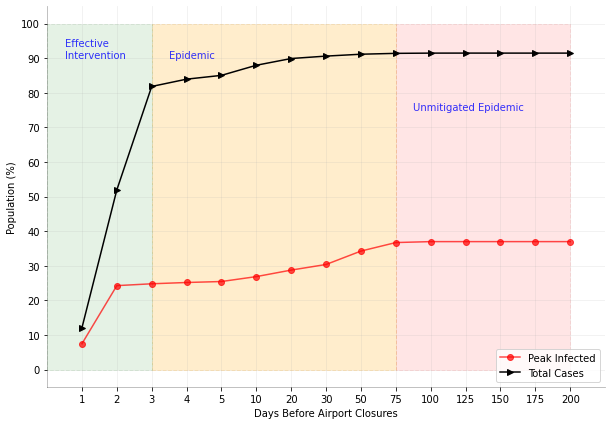

In [67]:
# Plot
n_days = len(x_axis_points)

plt.figure(figsize=(10,7))
results_df = pd.DataFrame(results).T
plt.plot(np.arange(0,results_df.shape[0]), results_df['peak_infections'] * 100, marker='o', c='r', alpha=0.7, label='Peak Infected')
plt.plot(np.arange(0,results_df.shape[0]), results_df['total_cases'] * 100, marker='>', c='k', label='Total Cases')
plt.xticks(np.arange(0,results_df.shape[0]),labels=results_df.index)
plt.yticks(np.arange(0,110,10))
plt.xlabel('Days Before Airport Closures')
plt.ylabel('Population (%)')
plt.legend(loc=4)
plt.grid(alpha=0.2)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color((0,0,0,0.3))
ax.spines['bottom'].set_color((0,0,0,0.3))

# plt.axvline(2, c='b', linestyle='--', alpha=0.5)
plt.fill_between(np.arange(2,10,1),100,0, linestyle='--', color='orange',alpha=0.2)
plt.annotate('Epidemic',(2.5,90), c='b', alpha = 0.8)


# plt.axvline(9, c='b', linestyle='--', alpha=0.5)
plt.fill_between(np.arange(9,n_days,1),100,0, linestyle='--', color='r',alpha=0.1)
plt.annotate('Unmitigated Epidemic',(9.5,75), c='b', alpha = 0.8)

plt.annotate('Effective\nIntervention',(-.5,90), c='b', alpha = 0.8)
plt.fill_between(np.arange(-1,3,1),100,0, linestyle='--', color='g',alpha=0.1)

plt.xlim(-1,n_days)

### Sensitivity Analysis

In [63]:
# RUN SIMULATIONS FOR VARIOUS DIFFERENT SEIRS PARAMETER VALUES
beta = 3
epsilon = 1/7
decay_vals = [0, 2.5, 5, 7.5, 10]
gamma_vals = [1/5, 1/25, 1/50]
n_steps = 200

stateHistories = np.zeros((len(decay_vals),len(gamma_vals))).tolist()
for idx_k, k in enumerate(gamma_vals):
    for idx_s, s in enumerate(decay_vals):
        print("gamma =", k, "decay =", s)

        env = EpidemicEnvironment(vals(adj_matrix), 
                                  vals(populations), 
                                  0, 
                                  0, 
                                  infected_idx = WUH, 
                                  alphas_plus = vals(alphas),
                                  lmbda = 10, 
                                  mu = 0.2, 
                                  centrality = centralities.values, 
                                  gamma = k, 
                                  beta = beta, 
                                  epsilon = epsilon,
                                  decay = s)

        env.reset()

        for i in range(n_steps):
            env.step(0)

        stateHistories[idx_s][idx_k] = env.stateHistory

gamma = 0.2 decay = 0
gamma = 0.2 decay = 2.5
gamma = 0.2 decay = 5
gamma = 0.2 decay = 7.5
gamma = 0.2 decay = 10
gamma = 0.04 decay = 0
gamma = 0.04 decay = 2.5
gamma = 0.04 decay = 5
gamma = 0.04 decay = 7.5
gamma = 0.04 decay = 10
gamma = 0.02 decay = 0
gamma = 0.02 decay = 2.5
gamma = 0.02 decay = 5
gamma = 0.02 decay = 7.5
gamma = 0.02 decay = 10


In [64]:
# RUN THE SIMULATION ALSO FOR A BENCHMARK SCENARIO WITH NO NETWORK STRUCTURE
stateHistories_0 = np.zeros((len(decay_vals),len(gamma_vals))).tolist()
for idx_k, k in enumerate(gamma_vals):
    for idx_s, s in enumerate(decay_vals):
        print("gamma =", k, "decay =", s)

        adj = np.zeros((1,1))
        pop = np.zeros((1,1))
        pop[0] = populations.sum() / populations.shape[0]

        env = EpidemicEnvironment(adj, 
                                  pop, 
                                  0, 
                                  0, 
                                  infected_idx = 0, 
                                  alphas_plus = np.ones((1,1)),
                                  lmbda = 10, 
                                  mu = 0.2, 
                                  centrality = np.ones((1,1)), 
                                  gamma = k, 
                                  beta = beta, 
                                  epsilon = epsilon,
                                  decay = s)

        for i in range(n_steps):
            env.step(0)

        stateHistories_0[idx_s][idx_k] = env.stateHistory

gamma = 0.2 decay = 0
gamma = 0.2 decay = 2.5
gamma = 0.2 decay = 5
gamma = 0.2 decay = 7.5
gamma = 0.2 decay = 10
gamma = 0.04 decay = 0
gamma = 0.04 decay = 2.5
gamma = 0.04 decay = 5
gamma = 0.04 decay = 7.5
gamma = 0.04 decay = 10
gamma = 0.02 decay = 0
gamma = 0.02 decay = 2.5
gamma = 0.02 decay = 5
gamma = 0.02 decay = 7.5
gamma = 0.02 decay = 10


In [68]:
# PRINT OUT THE RESULTS
IATA_results = {}
JFK = 3097
HKG = 1197
LHR = 147 # London Heathrow
ATL = 2880 # Atlanta
DXB = 3199 # Dubai

for IATA in [0, JFK, HKG, DXB, LHR, ATL]:
    IATA_results[IATA] = {
        'idx_first_grt_1000': np.zeros((len(decay_vals),len(gamma_vals))),
        'idx_last_grt_1000': np.zeros((len(decay_vals),len(gamma_vals))),
        'idx_max_I': np.zeros((len(decay_vals),len(gamma_vals))),
        'max_I': np.zeros((len(decay_vals),len(gamma_vals))),
    }   
    for idx_k, k in enumerate(gamma_vals):
        for idx_s, s in enumerate(decay_vals):
            sh = stateHistories[idx_s][idx_k]
            if IATA == 0:
                sh = stateHistories_0[idx_s][idx_k]

            idx_first_grt_1000 = (sh[:,2,IATA] > 10000).argmax()
            idx_max_I = sh[:,2,IATA].argmax()

            if len(sh[idx_max_I+1:,2,IATA]) > 0:
                idx_last_grt_1000 = idx_max_I + (sh[idx_max_I+1:,2,IATA] < 10000).argmax()
            else:
                idx_last_grt_1000 = -1

            max_I = sh[:,2,IATA].max()

            IATA_results[IATA]['idx_first_grt_1000'][idx_s,idx_k] = int(idx_first_grt_1000)
            IATA_results[IATA]['idx_max_I'][idx_s,idx_k] = int(idx_max_I)
            IATA_results[IATA]['idx_last_grt_1000'][idx_s,idx_k] = int(idx_last_grt_1000)
            IATA_results[IATA]['max_I'][idx_s,idx_k] = max_I

content = ""
cats = ['idx_max_I','max_I']
iata_map = {0: 'No Network', JFK:'JFK', HKG:'HKG', DXB:'DXB', LHR:'LHR', ATL:'ATL'}

for IATA in [0, JFK, HKG, DXB, LHR, ATL]:
    table = ""
    table += "\n\n----------------------\n\n"
    table += "Airport: " + iata_map[IATA]
    for stat in cats:
        table += "\n\nStat: " + stat + "\n"
        for idx_k, k in enumerate(gamma_vals):
            table += "\n" + '{0: >4}'.format(str(k))
            for idx_s, s in enumerate(decay_vals):
                value = '{0: >4}'.format(str(round(IATA_results[IATA][stat][idx_s,idx_k]/1e6,1)))
                if stat != "max_I":
                    value = '{0: >4}'.format(str(int(IATA_results[IATA][stat][idx_s,idx_k])))
                table += " & " + value
            table += " \\" + "\\"    
    print(table)



----------------------

Airport: No Network

Stat: idx_max_I

 0.2 &   30 &   32 &   34 &   37 &   41 \\
0.04 &   33 &   34 &   35 &   37 &   39 \\
0.02 &   36 &   37 &   38 &   40 &   41 \\

Stat: max_I

 0.2 &  0.7 &  0.6 &  0.6 &  0.6 &  0.5 \\
0.04 &  1.4 &  1.4 &  1.4 &  1.4 &  1.4 \\
0.02 &  1.7 &  1.7 &  1.7 &  1.7 &  1.7 \\


----------------------

Airport: JFK

Stat: idx_max_I

 0.2 &   59 &   67 &   81 &  109 &  105 \\
0.04 &   60 &   63 &   70 &   82 &  105 \\
0.02 &   61 &   66 &   75 &   85 &  105 \\

Stat: max_I

 0.2 &  2.8 &  2.7 &  2.2 &  0.8 &  0.0 \\
0.04 &  6.1 &  6.2 &  6.2 &  6.1 &  5.0 \\
0.02 &  7.4 &  7.6 &  7.7 &  7.8 &  7.4 \\


----------------------

Airport: HKG

Stat: idx_max_I

 0.2 &   46 &   51 &   58 &   70 &   87 \\
0.04 &   47 &   50 &   54 &   60 &   68 \\
0.02 &   51 &   55 &   57 &   62 &   70 \\

Stat: max_I

 0.2 &  9.4 &  9.0 &  8.2 &  6.3 &  2.1 \\
0.04 & 20.4 & 20.5 & 20.6 & 20.6 & 19.9 \\
0.02 & 24.8 & 25.0 & 25.2 & 25.4 & 25.5 \\


----

### N-th day rule

In [19]:
# NTH DAY RULE SIMULATIONS
days_max = 200
decay_values = [0, 5, 10]
disable_travel_after = [1,2,3,4,5,days_max]
experiments_nth_day_rule = {}
for decay_value in decay_values:
    print("\nDecay_value: ", decay_value)

    n_iters = days_max

    gamma = 1/25
    beta = 3
    eps = 1/7

    env = EpidemicEnvironment(vals(adj_matrix), 
                              vals(populations), 
                              ATL, 
                              get_community(ATL), 
                              infected_idx = WUH, 
                              alphas_plus = vals(alphas),
                              lmbda = 10, 
                              mu = 0.2, 
                              centrality = centralities.values, 
                              gamma = gamma, 
                              beta = beta, 
                              beta_reduced = beta, 
                              epsilon = eps,
                              decay = decay_value)


    for disable_timestep in disable_travel_after:
        print("Close after", disable_timestep, "days")
        env.reset()

        for i in range(disable_timestep):
            env.step(0)

        to_disable = close_airport_pct(0)
        env.set_disabled_airports(to_disable)

        for i in range(n_iters - disable_timestep):
            env.step(0)

        experiments_nth_day_rule[decay_value,disable_timestep] = env.stateHistory


Decay_value:  0
Close after 1 days
Close after 2 days
Close after 3 days
Close after 4 days
Close after 5 days
Close after 200 days

Decay_value:  5
Close after 1 days
Close after 2 days
Close after 3 days
Close after 4 days
Close after 5 days
Close after 200 days

Decay_value:  10
Close after 1 days
Close after 2 days
Close after 3 days
Close after 4 days
Close after 5 days
Close after 200 days


In [32]:
# PRINT OUT THE RESULTS FOR THE NTH DAY RULE
table_infection = ""
table_recovery = ""
for decay_value in decay_values:
    table_infection += '\n\\textbf{' + '{0: >3}'.format(str(decay_value)) + '}'
    table_recovery += '\n\\textbf{' + '{0: >3}'.format(str(decay_value)) + '}'
    for key in disable_travel_after:
        if key != disable_travel_after[-1]:
            total_population = experiments_nth_day_rule[decay_value,days_max][0,:,:].sum()

            infections_days_max = experiments_nth_day_rule[decay_value,days_max][:,2,:].sum(axis=1)
            infections = experiments_nth_day_rule[decay_value,key][:,2,:].sum(axis=1)
            reduced_pct_infections = (1 - (infections.max() / infections_days_max.max())) * 100
            table_infection += " & " + '{0: >7}'.format(str(round(reduced_pct_infections,1)))

            recoveries_days_max = experiments_nth_day_rule[decay_value,days_max][:,3,:].sum(axis=1)
            recoveries = experiments_nth_day_rule[decay_value,key][:,3,:].sum(axis=1)
            reduced_pct_recoveries = (1 - (recoveries.max() / recoveries_days_max.max())) * 100
            table_recovery += " & " + '{0: >7}'.format(str(round(reduced_pct_recoveries,1)))

        else:
            table_infection += " & " + '{0: >7}'.format(str(round(100*infections_days_max.max()/total_population,1)))
            table_recovery += " & " + '{0: >7}'.format(str(round(100*recoveries_days_max.max()/total_population,1)))


    table_infection += " \\" + "\\"
    table_recovery += " \\" + "\\"

print("\nNth day rule: % reduction on peak infection wrt worst scenario")
print(table_infection)
print("\nNth day rule: % reduction on total cases wrt worst scenario")
print(table_recovery)


Nth day rule: % reduction on peak infection wrt worst scenario

\textbf{  0} &    84.1 &    38.3 &    19.1 &    17.5 &    16.5 &    48.3 \\
\textbf{  5} &    79.8 &    34.4 &    33.0 &    32.0 &    31.2 &    37.0 \\
\textbf{ 10} &    60.2 &    58.8 &    57.9 &    57.2 &    56.7 &    15.1 \\

Nth day rule: % reduction on total cases wrt worst scenario

\textbf{  0} &    86.9 &    43.3 &     4.8 &     0.9 &     0.4 &    94.5 \\
\textbf{  5} &    86.8 &    43.2 &    10.5 &     8.2 &     7.0 &    91.5 \\
\textbf{ 10} &    77.1 &    76.3 &    75.1 &    73.7 &    72.1 &    51.0 \\


### Threshold rule

In [38]:
# THRESHOLD RULE SIMULATIONS
days_max = 200
decay_values = [0, 5, 10]
threshold_infections_after = [1e-7,1e-5,1e-3,1e-2,1e-1,-1]
experiments_threshold = {}
for decay_value in decay_values:
    print("\ndecay_value: ", decay_value)

    gamma = 1/25
    beta = 3
    eps = 1/7

    for threshold in threshold_infections_after:
        print("threshold_value: ", threshold)
        env = EpidemicEnvironment(vals(adj_matrix), 
                                  vals(populations), 
                                  ATL, 
                                  get_community(ATL), 
                                  infected_idx = WUH, 
                                  alphas_plus = vals(alphas),
                                  lmbda = 10, 
                                  mu = 0.2, 
                                  centrality = centralities.values, 
                                  gamma = gamma, 
                                  beta = beta, 
                                  epsilon = eps,
                                  beta_reduced = beta, 
                                  lockdown_threshold = -1,
                                  decay = decay_value)

        env.reset()

        for i in range(days_max):
            env.step(0)
            env.lockdown_threshold = threshold

        experiments_threshold[decay_value,threshold] = env.stateHistory


decay_value:  0
threshold_value:  1e-07
threshold_value:  1e-05
threshold_value:  0.001
threshold_value:  0.01
threshold_value:  0.1
threshold_value:  -1

decay_value:  5
threshold_value:  1e-07
threshold_value:  1e-05
threshold_value:  0.001
threshold_value:  0.01
threshold_value:  0.1
threshold_value:  -1

decay_value:  10
threshold_value:  1e-07
threshold_value:  1e-05
threshold_value:  0.001
threshold_value:  0.01
threshold_value:  0.1
threshold_value:  -1


In [41]:
# PRINT OUT THE RESULTS FOR THE THRESHOLD RULE
table_infection = ""
table_recovery = ""
for decay_value in decay_values:
    table_infection += '\n\\textbf{' + '{0: >3}'.format(str(decay_value)) + '}'
    table_recovery += '\n\\textbf{' + '{0: >3}'.format(str(decay_value)) + '}'
    for key in threshold_infections_after:
        if key != threshold_infections_after[-1]:
            total_population = experiments_threshold[decay_value,-1][0,:,:].sum()

            infections_days_max = experiments_threshold[decay_value,-1][:,2,:].sum(axis=1)
            infections = experiments_threshold[decay_value,key][:,2,:].sum(axis=1)
            reduced_pct_infections = (1 - (infections.max() / infections_days_max.max())) * 100
            table_infection += " & " + '{0: >7}'.format(str(round(reduced_pct_infections,1)))

            recoveries_days_max = experiments_threshold[decay_value,-1][:,3,:].sum(axis=1)
            recoveries = experiments_threshold[decay_value,key][:,3,:].sum(axis=1)
            reduced_pct_recoveries = (1 - (recoveries.max() / recoveries_days_max.max())) * 100
            table_recovery += " & " + '{0: >7}'.format(str(round(reduced_pct_recoveries,1)))
        
        else:
            table_infection += " & " + '{0: >7}'.format(str(round(100*infections_days_max.max()/total_population,1)))
            table_recovery += " & " + '{0: >7}'.format(str(round(100*recoveries_days_max.max()/total_population,1)))
        
    table_infection += " \\" + "\\"
    table_recovery += " \\" + "\\"

print("\nThreshold rule: % reduction on peak infection wrt worst scenario")
print(table_infection)
print("\nThreshold rule: % reduction on total cases wrt worst scenario")
print(table_recovery)


Threshold rule: % reduction on peak infection wrt worst scenario

\textbf{  0} &     2.2 &     1.5 &     1.0 &     0.6 &     0.3 &    48.3 \\
\textbf{  5} &    15.5 &    10.3 &     5.5 &     3.6 &     1.9 &    37.0 \\
\textbf{ 10} &    56.8 &    52.2 &    32.8 &    19.8 &    10.1 &    15.1 \\

Threshold rule: % reduction on total cases wrt worst scenario

\textbf{  0} &     0.0 &     0.0 &     0.0 &    -0.0 &    -0.0 &    94.5 \\
\textbf{  5} &     0.9 &     0.5 &     0.2 &     0.1 &     0.0 &    91.5 \\
\textbf{ 10} &    65.8 &    48.4 &    26.8 &    16.3 &     8.5 &    51.0 \\


### Limited N-th day rule

In [46]:
# LIMITED NTH DAY RULE SIMULATIONS
days_max = 200
metrics_dict = {'populations':populations, 'centrality':centralities, 'betweeness':betweeness}
fraction_to_disable_set = [0.01,0.05,0.1,0.25,1]
disable_after_n_days = [1,2,3,4,5,days_max]
experiments_limited = {}
for metric_name, metric in metrics_dict.items():
    print('Metric: ', metric_name)
    
    for fraction_to_disable in fraction_to_disable_set:
        print('Fraction to disable: ', fraction_to_disable)
        
        n_iters = days_max
        gamma = 1/25
        beta = 3
        eps = 1/7
        decay = 5

        env = EpidemicEnvironment(vals(adj_matrix), 
                                  vals(populations), 
                                  ATL, 
                                  get_community(ATL), 
                                  infected_idx = WUH, 
                                  alphas_plus = vals(alphas), 
                                  lmbda = 10, 
                                  mu = 0.2, 
                                  centrality = centralities.values, 
                                  gamma = gamma, 
                                  beta = beta, 
                                  epsilon = eps, 
                                  beta_reduced = beta,
                                  decay = decay)

        for n_days in disable_after_n_days:
            print('Close at day: ', n_days)
            env.reset()

            for i in range(n_days):
                env.step(0)

            to_disable = close_airport_pct(0, metric)
            if n_days != days_max:
                to_disable = close_airport_pct(1 - fraction_to_disable, metric)
                
            env.set_disabled_airports(to_disable)

            for i in range(n_iters - n_days):
                env.step(0)

            experiments_limited[metric_name, fraction_to_disable, n_days] = env.stateHistory

Metric:  populations
Fraction to disable:  0.01
Close at day:  1
Close at day:  2
Close at day:  3
Close at day:  4
Close at day:  5
Close at day:  200
Fraction to disable:  0.05
Close at day:  1
Close at day:  2
Close at day:  3
Close at day:  4
Close at day:  5
Close at day:  200
Fraction to disable:  0.1
Close at day:  1
Close at day:  2
Close at day:  3
Close at day:  4
Close at day:  5
Close at day:  200
Fraction to disable:  0.25
Close at day:  1
Close at day:  2
Close at day:  3
Close at day:  4
Close at day:  5
Close at day:  200
Fraction to disable:  1
Close at day:  1
Close at day:  2
Close at day:  3
Close at day:  4
Close at day:  5
Close at day:  200
Metric:  centrality
Fraction to disable:  0.01
Close at day:  1
Close at day:  2
Close at day:  3
Close at day:  4
Close at day:  5
Close at day:  200
Fraction to disable:  0.05
Close at day:  1
Close at day:  2
Close at day:  3
Close at day:  4
Close at day:  5
Close at day:  200
Fraction to disable:  0.1
Close at day:  1
Clo

In [50]:
# PRINT OUT THE RESULTS FOR THE LIMITED NTH DAY RULE
table_infection = ""
table_recovery = ""
for metric_name, metric in metrics_dict.items():
    table_infection += "\n\nMetric: " + metric_name + "\n"
    table_recovery += "\n\nMetric: " + metric_name + "\n"
    for fraction_to_disable in fraction_to_disable_set:
        table_infection += '\n\\textbf{' + '{0: >4}'.format(str(round(100*fraction_to_disable))) + '\\%}'
        table_recovery += '\n\\textbf{' + '{0: >4}'.format(str(round(100*fraction_to_disable))) + '\\%}'
        for n_days in disable_after_n_days:
            if n_days != disable_after_n_days[-1]:
                total_population = experiments_limited[metric_name,fraction_to_disable,days_max][0,:,:].sum()

                infections_days_max = experiments_limited[metric_name,fraction_to_disable,days_max][:,2,:].sum(axis=1)
                infections = experiments_limited[metric_name,fraction_to_disable,n_days][:,2,:].sum(axis=1)
                reduced_pct_infections = (1 - (infections.max() / infections_days_max.max())) * 100
                table_infection += " & " + '{0: >7}'.format(str(round(reduced_pct_infections,1)))

                recoveries_days_max = experiments_limited[metric_name,fraction_to_disable,days_max][:,3,:].sum(axis=1)
                recoveries = experiments_limited[metric_name,fraction_to_disable,n_days][:,3,:].sum(axis=1)
                reduced_pct_recoveries = (1 - (recoveries.max() / recoveries_days_max.max())) * 100
                table_recovery += " & " + '{0: >7}'.format(str(round(reduced_pct_recoveries,1)))

            else:
                table_infection += " & " + '{0: >7}'.format(str(round(100*infections_days_max.max()/total_population,1)))
                table_recovery += " & " + '{0: >7}'.format(str(round(100*recoveries_days_max.max()/total_population,1)))
        
        table_infection += " \\" + "\\"
        table_recovery += " \\" + "\\"

print("\n\n\nLimited Nth day rule: % reduction on peak infection wrt worst scenario")
print(table_infection)
print("\n\n\nLimited Nth day rule: % reduction on total cases wrt worst scenario")
print(table_recovery)




Limited Nth day rule: % reduction on peak infection wrt worst scenario


Metric: populations

\textbf{   1\%} &    30.1 &     9.4 &     8.4 &     7.8 &     7.5 &    37.0 \\
\textbf{   5\%} &    64.0 &    21.1 &    20.1 &    19.4 &    19.0 &    37.0 \\
\textbf{  10\%} &    79.7 &    29.6 &    28.2 &    27.2 &    26.5 &    37.0 \\
\textbf{  25\%} &    79.8 &    33.7 &    32.3 &    31.3 &    30.5 &    37.0 \\
\textbf{ 100\%} &    79.8 &    34.4 &    33.0 &    32.0 &    31.2 &    37.0 \\

Metric: centrality

\textbf{   1\%} &    19.3 &    11.0 &    10.0 &     9.4 &     8.9 &    37.0 \\
\textbf{   5\%} &    74.0 &    31.7 &    29.8 &    28.6 &    27.8 &    37.0 \\
\textbf{  10\%} &    79.5 &    34.1 &    32.5 &    31.4 &    30.5 &    37.0 \\
\textbf{  25\%} &    79.8 &    34.3 &    32.9 &    31.9 &    31.1 &    37.0 \\
\textbf{ 100\%} &    79.8 &    34.4 &    33.0 &    32.0 &    31.2 &    37.0 \\

Metric: betweeness

\textbf{   1\%} &    17.8 &     9.4 &     8.7 &     8.2 &     7.8 &    